<h1>MOMENT Embeddings for Eye-Tracking Data — s_002</h1>
<hr>


## Contents
### 1. Introduction
### 2. Loading MOMENT
### 3. Loading & Preprocessing Eye-Tracking Data
### 4. Windowing
### 5. Computing MOMENT Embeddings
### 6. Visualizing Embeddings (PCA)


## 1. A Quick Introduction to Representation Learning


Learning universal representation for time series is an important and challenging problem. In this tutorial, we will show you how you can use MOMENT to get useful embeddings from time series data. 

Mathematically, our the unsupervised representation learning problem is as follows:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), the representation learning problem involves learning representations that effectively capture the temporal dynamics of time series data. 

In this tutorial, we will learn these representations without any labeled data (unsupervised representation learning). We will also learn instance-level representations i.e. learn a fixed-dimensional representation for a time series sequence, instead of learning representation for each individual time step. 

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model. 

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding` model, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `classification.ipynb` notebook for more details! 

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [40]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={'task_name': 'embedding'}, # We are loading the model in `embedding` mode to learn representations
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [41]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [42]:
# Number of parameters in the encoder
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 341231104


## 3. Loading & Preprocessing Eye-Tracking Data

The recording (`s_002.csv`) was collected with a Tobii eye tracker at ~60 Hz and contains the following channels we will use:

| Channel | Description |
|---|---|
| `GazePointX` | Horizontal gaze position (combined, pixels) |
| `GazePointY` | Vertical gaze position (combined, pixels) |
| `PupilSizeLeft` | Left pupil diameter (mm) |
| `PupilSizeRight` | Right pupil diameter (mm) |

**Invalid samples** (validity = 0, value = –1.0) are handled as follows:
- Consecutive invalid runs **shorter than `MAX_INVALID_FRAMES`** (~1 s at 60 Hz) are **linearly interpolated**.
- Sliding windows that still contain any value from a longer invalid run are **dropped**.


In [43]:
import numpy as np
import pandas as pd
from pathlib import Path

# ── Configuration ──────────────────────────────────────────────────────────────
DATA_PATH = Path("../../trustME_CLUES/data/raw/sample/s_002/tobii/s_002.csv")

CHANNELS = ["GazePointX", "GazePointY", "PupilSizeLeft", "PupilSizeRight"]

# Tobii validity: 4 = valid, 0 = invalid.  Mirror: -1.0 sentinel in gaze columns.
MAX_INVALID_FRAMES = 60   # ~1 s at 60 Hz; longer runs → window dropped

# ── Load ───────────────────────────────────────────────────────────────────────
df_raw = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df_raw):,} rows | columns: {df_raw.columns.tolist()}")
print(f"Labels: {df_raw['label'].unique()}")
print(f"Timestamp range: {df_raw['timestamp'].min():.2f} – {df_raw['timestamp'].max():.2f} s")
approx_fs = 1 / df_raw["timestamp"].diff().median()
print(f"Approx. sampling rate: {approx_fs:.1f} Hz")


Loaded 142,369 rows | columns: ['timestamp', 'Event', 'GazePointXLeft', 'GazePointYLeft', 'ValidityLeft', 'GazePointXRight', 'GazePointYRight', 'ValidityRight', 'GazePointX', 'GazePointY', 'PupilSizeLeft', 'PupilValidityLeft', 'PupilSizeRight', 'PupilValidityRight', 'label']
Labels: <StringArray>
[           'central_position',               'questionnaire',
                      '2_back',                      '3_back',
                 'stroop_easy',            'stroop_difficult',
                        'rest',                 'memory_easy',
            'memory_difficult',       'images_questions_easy',
  'images_questions_difficult',                'listen_music',
      'difference_images_easy', 'difference_images_difficult',
                'pursuit_easy',           'pursuit_difficult',
             'passive_viewing']
Length: 17, dtype: str
Timestamp range: 0.00 – 2381.35 s
Approx. sampling rate: 60.4 Hz


In [44]:
def preprocess_eyetracking(
    df: pd.DataFrame,
    channels: list[str],
    max_invalid_frames: int,
) -> pd.DataFrame:
    """Extract channels, interpolate short invalid runs, flag long ones.

    Parameters
    ----------
    df : raw DataFrame from CSV
    channels : list of column names to keep
    max_invalid_frames : consecutive invalid frames threshold;
                         runs >= this value are flagged as 'has_long_gap'

    Returns
    -------
    DataFrame with columns = channels + ['has_long_gap', 'label', 'timestamp']
    """
    signals = df[channels].copy().astype(float)

    # Mark invalid samples as NaN (Tobii uses –1.0 sentinel for invalid gaze)
    invalid_mask = (signals == -1.0).any(axis=1)
    signals[invalid_mask] = np.nan

    # Measure consecutive NaN run lengths per row
    is_nan = signals.isnull().any(axis=1).to_numpy(dtype=int)
    run_lengths = np.zeros(len(is_nan), dtype=int)
    run_len = 0
    for i in range(len(is_nan)):
        if is_nan[i]:
            run_len += 1
        else:
            if run_len > 0:
                run_lengths[i - run_len : i] = run_len
            run_len = 0
    if run_len > 0:
        run_lengths[len(is_nan) - run_len :] = run_len

    # Interpolate short gaps (limit = max_invalid_frames - 1 so gaps of exactly
    # max_invalid_frames remain NaN and will be caught by has_long_gap flag)
    signals = signals.interpolate(method="linear", limit=max_invalid_frames - 1)
    signals = signals.ffill().bfill()  # handle leading / trailing NaNs

    signals["has_long_gap"] = run_lengths >= max_invalid_frames
    signals["label"] = df["label"].values
    signals["timestamp"] = df["timestamp"].values
    return signals


df_clean = preprocess_eyetracking(df_raw, CHANNELS, MAX_INVALID_FRAMES)
n_long_gap = df_clean["has_long_gap"].sum()
print(f"Preprocessed {len(df_clean):,} rows")
print(f"Rows flagged as part of a long invalid run: {n_long_gap:,} ({n_long_gap/len(df_clean)*100:.1f} %)")
print(df_clean[CHANNELS].describe().round(2))


Preprocessed 142,369 rows
Rows flagged as part of a long invalid run: 37,838 (26.6 %)
       GazePointX  GazePointY  PupilSizeLeft  PupilSizeRight
count   142369.00   142369.00      142369.00       142369.00
mean       975.97      632.07           2.50            2.48
std        399.87      472.65           0.18            0.17
min       -374.00     -209.00           1.30            1.34
25%        792.89      423.00           2.39            2.38
50%        935.00      508.00           2.48            2.50
75%       1090.00      648.50           2.62            2.58
max       2292.00     2370.00           3.86            4.51


## 4. Windowing

MOMENT requires fixed-length input of exactly **512 timesteps**. We use a sliding window over the preprocessed signal:

- `CONTEXT_LENGTH = 512` — 512 samples ≈ 8.5 s at 60 Hz  
- `STRIDE` — step size between consecutive windows (configurable)  

For each window we record:
- The **majority label** across its 512 rows  
- An **`input_mask`** (all-ones here, since we have already handled NaNs via interpolation)  

Windows that overlap with a long invalid run are **dropped**.


In [45]:
import torch

# ── Configuration ──────────────────────────────────────────────────────────────
CONTEXT_LENGTH = 512   # MOMENT's required input length
STRIDE = 256           # step between consecutive windows (50 % overlap)


def make_windows(
    df: pd.DataFrame,
    channels: list[str],
    context_length: int,
    stride: int,
) -> tuple[np.ndarray, np.ndarray, list[str]]:
    """Slide a fixed-length window over the signal.

    Parameters
    ----------
    df : preprocessed DataFrame (output of preprocess_eyetracking)
    channels : feature columns to extract
    context_length : window size in samples
    stride : step between windows in samples

    Returns
    -------
    windows      : float32 array of shape (N, n_channels, context_length)
    input_masks  : int32 array of shape (N, context_length) — all ones
    labels       : list of N majority-vote label strings
    """
    signals = df[channels].to_numpy(dtype=np.float32)        # (T, C)
    has_gap = df["has_long_gap"].to_numpy(dtype=bool)         # (T,)
    label_arr = df["label"].to_numpy()                        # (T,)

    n_total = len(signals)
    windows, input_masks, labels = [], [], []

    for start in range(0, n_total - context_length + 1, stride):
        end = start + context_length
        if has_gap[start:end].any():
            continue  # skip windows touching long invalid runs

        win = signals[start:end].T                            # (C, context_length)

        # z-score normalise each channel independently within the window
        mean = win.mean(axis=1, keepdims=True)
        std  = win.std(axis=1, keepdims=True) + 1e-8
        win  = (win - mean) / std

        # majority label
        unique, counts = np.unique(label_arr[start:end], return_counts=True)
        majority_label = unique[counts.argmax()]

        windows.append(win)
        input_masks.append(np.ones(context_length, dtype=np.int32))
        labels.append(majority_label)

    windows_arr     = np.stack(windows)                       # (N, C, context_length)
    input_masks_arr = np.stack(input_masks)                   # (N, context_length)
    return windows_arr, input_masks_arr, labels


windows, input_masks, window_labels = make_windows(df_clean, CHANNELS, CONTEXT_LENGTH, STRIDE)
print(f"Created {len(windows):,} windows  |  shape: {windows.shape}")
print(f"Label distribution across windows:")
unique_labels, counts = np.unique(window_labels, return_counts=True)
for lbl, cnt in sorted(zip(unique_labels, counts), key=lambda x: -x[1]):
    print(f"  {lbl:<35s} {cnt:5d} ({cnt/len(window_labels)*100:.1f} %)")


Created 343 windows  |  shape: (343, 4, 512)
Label distribution across windows:
  questionnaire                         103 (30.0 %)
  3_back                                 29 (8.5 %)
  stroop_easy                            29 (8.5 %)
  2_back                                 28 (8.2 %)
  stroop_difficult                       28 (8.2 %)
  listen_music                           27 (7.9 %)
  passive_viewing                        23 (6.7 %)
  images_questions_difficult             19 (5.5 %)
  images_questions_easy                  14 (4.1 %)
  difference_images_difficult            10 (2.9 %)
  pursuit_difficult                      10 (2.9 %)
  rest                                    9 (2.6 %)
  pursuit_easy                            6 (1.7 %)
  memory_easy                             5 (1.5 %)
  memory_difficult                        3 (0.9 %)


## 5. Computing MOMENT Embeddings

We run inference in mini-batches to avoid GPU OOM. Each window (shape `[C=4, 512]`) is passed through the pre-trained MOMENT encoder. The output `embeddings` tensor has shape `(N, 1024)`.


In [46]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Convert to tensors
x_tensor     = torch.from_numpy(windows).float()           # (N, C, T)
mask_tensor  = torch.from_numpy(input_masks).long()        # (N, T)

dataset    = TensorDataset(x_tensor, mask_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

model.to(DEVICE)
model.eval()

all_embeddings = []
with torch.no_grad():
    for x_batch, mask_batch in tqdm(dataloader, desc="Embedding"):
        x_batch    = x_batch.to(DEVICE)
        mask_batch = mask_batch.to(DEVICE)
        output     = model(x_enc=x_batch, input_mask=mask_batch)
        all_embeddings.append(output.embeddings.cpu().numpy())

embeddings = np.concatenate(all_embeddings, axis=0)   # (N, 1024)
print(f"Embeddings shape: {embeddings.shape}")


Using device: cuda


Embedding: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

Embeddings shape: (343, 1024)


## 6. Visualizing Embeddings (PCA)

We project the 1024-dimensional embeddings to 2D with PCA and colour each point by its majority label. Well-separated clusters suggest that MOMENT captures task-relevant signal differences in the eye-tracking data.


In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ── PCA projection ─────────────────────────────────────────────────────────────
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)
print(f"Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.3f}, "
      f"PC2={pca.explained_variance_ratio_[1]:.3f}")


Explained variance ratio: PC1=0.260, PC2=0.196


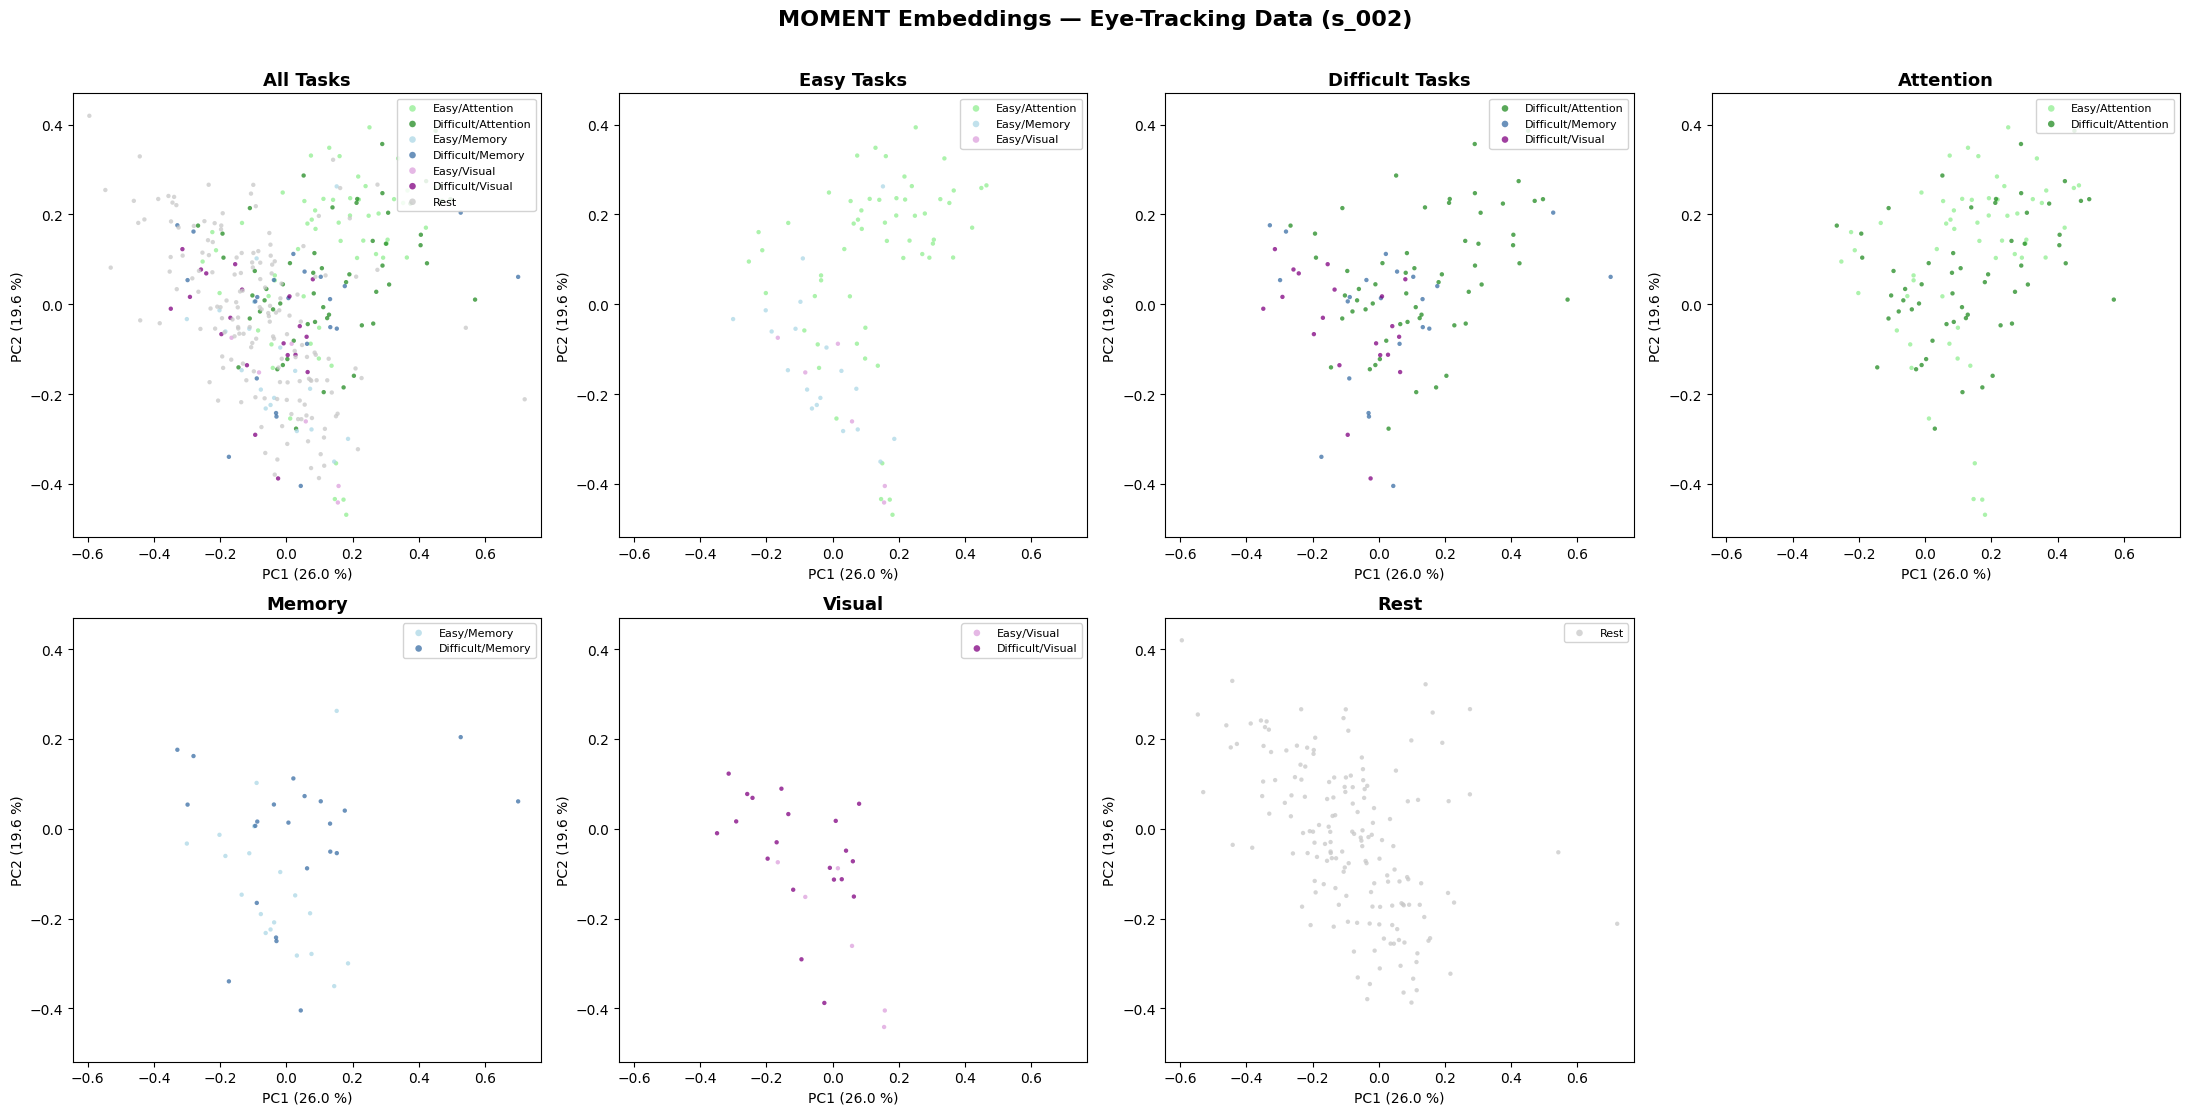

In [48]:
# ── Color mapping matching project color scheme ────────────────────────────────
LEGEND_GROUPS = {
    "Easy/Attention":      "#90EE90",
    "Difficult/Attention": "#228B22",
    "Easy/Memory":         "#ADD8E6",
    "Difficult/Memory":    "#3A6EA5",
    "Easy/Visual":         "#DDA0DD",
    "Difficult/Visual":    "#800080",
    "Rest":                "#C8C8C8",
}

LABEL_TO_GROUP = {
    "2_back":                      "Easy/Attention",
    "stroop_easy":                 "Easy/Attention",
    "3_back":                      "Difficult/Attention",
    "stroop_difficult":            "Difficult/Attention",
    "memory_easy":                 "Easy/Memory",
    "images_questions_easy":       "Easy/Memory",
    "memory_difficult":            "Difficult/Memory",
    "images_questions_difficult":  "Difficult/Memory",
    "pursuit_easy":                "Easy/Visual",
    "difference_images_easy":      "Easy/Visual",
    "pursuit_difficult":           "Difficult/Visual",
    "difference_images_difficult": "Difficult/Visual",
    "rest":                        "Rest",
    "listen_music":                "Rest",
    "passive_viewing":             "Rest",
    "central_position":            "Rest",
    "questionnaire":               "Rest",
}

label_arr = np.array(window_labels)

# ── Shared axis limits (computed from the full dataset) ───────────────────────
_pad = 0.05
x_min, x_max = emb_2d[:, 0].min() - _pad, emb_2d[:, 0].max() + _pad
y_min, y_max = emb_2d[:, 1].min() - _pad, emb_2d[:, 1].max() + _pad

# ── Panel definitions ─────────────────────────────────────────────────────────
# Each entry: (title, set of group names to show in this panel)
PANELS = [
    ("All Tasks",         set(LEGEND_GROUPS.keys())),
    ("Easy Tasks",        {"Easy/Attention", "Easy/Memory", "Easy/Visual"}),
    ("Difficult Tasks",   {"Difficult/Attention", "Difficult/Memory", "Difficult/Visual"}),
    ("Attention",         {"Easy/Attention", "Difficult/Attention"}),
    ("Memory",            {"Easy/Memory", "Difficult/Memory"}),
    ("Visual",            {"Easy/Visual", "Difficult/Visual"}),
    ("Rest",              {"Rest"}),
]

# ── Plotting ──────────────────────────────────────────────────────────────────
N_COLS = 4
N_ROWS = 2
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(22, 11))
axes = axes.flatten()

for ax_idx, (title, active_groups) in enumerate(PANELS):
    ax = axes[ax_idx]

    for group_name, group_color in LEGEND_GROUPS.items():
        if group_name not in active_groups:
            continue
        group_labels = [lbl for lbl, grp in LABEL_TO_GROUP.items() if grp == group_name]
        mask = np.isin(label_arr, group_labels)
        if not mask.any():
            continue
        ax.scatter(
            emb_2d[mask, 0],
            emb_2d[mask, 1],
            c=group_color,
            label=group_name,
            s=10,
            alpha=0.75,
            edgecolors="none",
        )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f} %)", fontsize=10)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f} %)", fontsize=10)
    ax.legend(fontsize=8, loc="upper right", framealpha=0.85, markerscale=1.5)

# Hide the unused last subplot slot
axes[-1].set_visible(False)

fig.suptitle("MOMENT Embeddings — Eye-Tracking Data (s_002)", fontsize=16, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()


### Results

Each point in the scatter plot is a 512-sample (~8.5 s) window of eye-tracking data from participant s_002, coloured by the cognitive/behavioural task being performed.

Visible cluster separation suggests that the zero-shot MOMENT embeddings already encode task-discriminative patterns in the eye-movement & pupil dilation signals, even without any fine-tuning on eye-tracking data.

The `embeddings` array (shape `N × 1024`) and `window_labels` list can now be used as inputs to downstream classifiers, clustering algorithms, or further fine-tuning.


## 7. What Else Can We Do? — Exploration

Three axes worth exploring to potentially get better embeddings.

---

### 7.1 Available Pre-trained Weights

AutonLab publishes **three MOMENT-1 checkpoints** on HuggingFace, all sharing the same architecture but with different T5 backbone sizes:

| Model ID | Backbone | Downloads | Notes |
|---|---|---|---|
| `AutonLab/MOMENT-1-large` | flan-t5-large → **0.3 B params** | ~93k | **currently used** |
| `AutonLab/MOMENT-1-base` | flan-t5-base → ~250 M params | ~79k | good speed/quality trade-off |
| `AutonLab/MOMENT-1-small` | flan-t5-small → ~77 M params | ~63k | fastest, least expressive |

`large` is almost certainly the best for embedding quality; `small`/`base` are worth testing only if inference speed is a bottleneck.

---

### 7.2 Fine-tuning Options

The pre-trained encoder is **frozen by default** (`freeze_encoder=True`). Three practical strategies:

| Strategy | What trains | When to use |
|---|---|---|
| **Linear probe** (current) | Nothing — zero-shot | Baseline; no labels needed |
| **Linear probe + projection head** | Small MLP on top of embeddings | A few hundred labelled windows |
| **Classification fine-tune** | Linear head only (encoder still frozen) | Most practical with limited ET data |
| **Full fine-tune** | Entire model (`freeze_encoder=False`) | Large labelled dataset; risk of catastrophic forgetting |

> **Note:** only the `reconstruction` head is pre-trained. Classification & forecasting heads are randomly initialised and *must* be fine-tuned before use.

---

### 7.3 How Much Does Segmentation Matter?

Three segmentation knobs directly affect what MOMENT sees:

| Parameter | Current value | Alternatives to try |
|---|---|---|
| `CONTEXT_LENGTH` | 512 (~8.5 s) | 256 (~4.3 s), 128 (~2.1 s) — more windows, less context |
| `STRIDE` | 256 (50 % overlap) | 512 (no overlap = faster), 128 (75 % overlap = smoother) |
| `reduction` (inside MOMENT) | `"mean"` — averages over patches & channels → shape `(1024,)` | `"none"` — keeps per-patch representations → shape `(n_patches, 1024)`, then aggregate yourself |

**Important — MOMENT always requires exactly 512 timesteps as input.**  
The model's `seq_len=512` is baked into the pre-trained positional embeddings (64 patches × patch_len 8). Passing a shorter tensor directly would silently produce fewer patches and corrupt the positional encoding, giving wrong embeddings.

For context windows shorter than 512 the correct approach is:
1. **Right-pad** the window to 512 samples with zeros.
2. **Set `input_mask=0`** on the padded region — MOMENT's masked mean in `embed()` then computes the average only over the real patches and ignores the padding entirely.

This is the standard MOMENT idiom for variable-length inputs (e.g. short or irregularly-sampled series).

The cell below runs a **small comparison experiment**: it computes embeddings for a grid of `(context_length, stride, reduction)` settings — with proper padding — and shows the PCA scatter for the *All Tasks* panel for each combination.


In [49]:
from itertools import product as iproduct

# ── Experiment grid ───────────────────────────────────────────────────────────
CONTEXT_LENGTHS = [128, 256, 512]   # window sizes in samples
STRIDES         = [64,  128, 256]   # must be <= context_length
REDUCTIONS      = ["mean", "none"]  # "none" → per-patch; we max-pool to (1024,)

model.to(DEVICE)
model.eval()


MOMENT_SEQ_LEN = 512  # fixed input length required by the pre-trained model


def compute_embeddings_grid(
    df: pd.DataFrame,
    context_length: int,
    stride: int,
    reduction: str,
    channels: list[str] = CHANNELS,
    batch_size: int = 64,
) -> tuple[np.ndarray, list[str]]:
    """Compute MOMENT embeddings for a given (context_length, stride, reduction) triple.

    MOMENT requires exactly MOMENT_SEQ_LEN=512 timesteps. When context_length < 512
    the windows are right-padded with zeros and input_mask is set to 0 on the
    padded region so MOMENT's masked mean ignores those positions.

    For reduction='none' the per-patch tensor is max-pooled to (d_model,) per window.
    """
    wins, masks, labels = make_windows(df, channels, context_length, stride)
    # wins  : (N, C, context_length)
    # masks : (N, context_length)  — all ones from make_windows

    if context_length < MOMENT_SEQ_LEN:
        pad_len = MOMENT_SEQ_LEN - context_length
        # Pad signal dimension to 512 with zeros
        wins  = np.pad(wins,  ((0, 0), (0, 0), (0, pad_len)), mode="constant", constant_values=0.0)
        # Extend mask: 1 for real samples, 0 for padding
        masks = np.pad(masks, ((0, 0), (0, pad_len)),          mode="constant", constant_values=0)

    x_t   = torch.from_numpy(wins).float()
    msk_t = torch.from_numpy(masks).long()

    dl = DataLoader(TensorDataset(x_t, msk_t), batch_size=batch_size, shuffle=False)
    all_embs = []
    with torch.no_grad():
        for xb, mb in dl:
            out = model(x_enc=xb.to(DEVICE), input_mask=mb.to(DEVICE), reduction=reduction)
            emb = out.embeddings.cpu().numpy()
            if reduction == "none":
                # emb shape: (B, n_patches, d_model) after mean over channels
                # max-pool across the patch dimension → (B, d_model)
                if emb.ndim == 4:            # (B, C, P, D) — shouldn't occur for embed
                    emb = emb.max(axis=2).max(axis=1)
                elif emb.ndim == 3:          # (B, P, D)
                    emb = emb.max(axis=1)
            all_embs.append(emb)
    return np.concatenate(all_embs, axis=0), labels


# Pre-compute all combinations (this may take a few minutes)
results = {}
total = len(CONTEXT_LENGTHS) * len(STRIDES) * len(REDUCTIONS)
done  = 0

for ctx, stride, red in iproduct(CONTEXT_LENGTHS, STRIDES, REDUCTIONS):
    if stride > ctx:
        done += 1
        continue

    key = (ctx, stride, red)
    print(f"[{done+1}/{total}] ctx={ctx}  stride={stride}  reduction={red} ...", end=" ", flush=True)
    embs, lbls = compute_embeddings_grid(df_clean, ctx, stride, red)
    # PCA to 2D (re-fit per setting for comparability)
    emb2d = PCA(n_components=2, random_state=42).fit_transform(embs)
    results[key] = (emb2d, np.array(lbls))
    done += 1
    print(f"→ {len(embs)} windows, emb shape {embs.shape}")

print("Done.")


[1/18] ctx=128  stride=64  reduction=mean ... → 1555 windows, emb shape (1555, 1024)
[2/18] ctx=128  stride=64  reduction=none ... → 1555 windows, emb shape (1555, 1024)
[3/18] ctx=128  stride=128  reduction=mean ... → 775 windows, emb shape (775, 1024)
[4/18] ctx=128  stride=128  reduction=none ... → 775 windows, emb shape (775, 1024)
[7/18] ctx=256  stride=64  reduction=mean ... → 1483 windows, emb shape (1483, 1024)
[8/18] ctx=256  stride=64  reduction=none ... → 1483 windows, emb shape (1483, 1024)
[9/18] ctx=256  stride=128  reduction=mean ... → 741 windows, emb shape (741, 1024)
[10/18] ctx=256  stride=128  reduction=none ... → 741 windows, emb shape (741, 1024)
[11/18] ctx=256  stride=256  reduction=mean ... → 372 windows, emb shape (372, 1024)
[12/18] ctx=256  stride=256  reduction=none ... → 372 windows, emb shape (372, 1024)
[13/18] ctx=512  stride=64  reduction=mean ... → 1365 windows, emb shape (1365, 1024)
[14/18] ctx=512  stride=64  reduction=none ... → 1365 windows, emb 

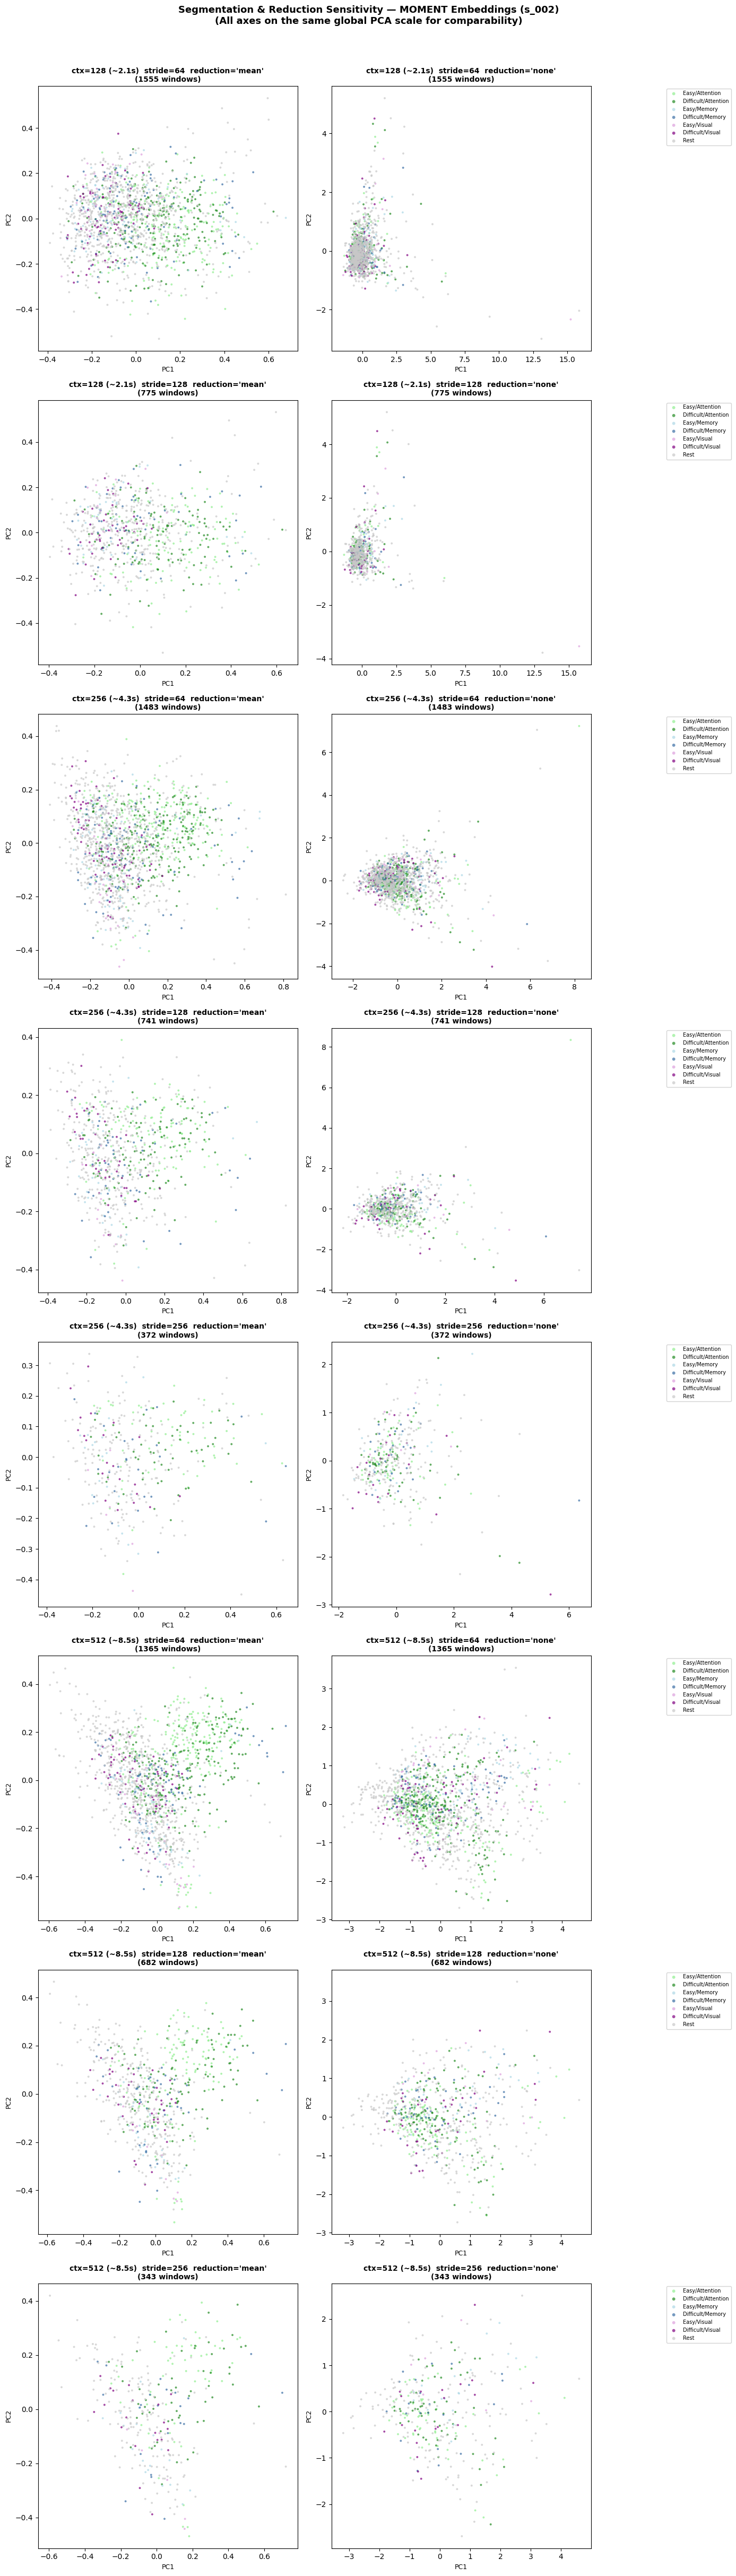

In [50]:
# ── Visualise: one "All Tasks" PCA panel per (ctx, stride, reduction) combination
valid_keys  = sorted(results.keys())   # (ctx, stride, reduction)
n_plots     = len(valid_keys)

N_COLS_G    = len(REDUCTIONS)          # columns = reductions
N_ROWS_G    = len(valid_keys) // N_COLS_G + (1 if len(valid_keys) % N_COLS_G else 0)

fig, axes = plt.subplots(N_ROWS_G, N_COLS_G, figsize=(N_COLS_G * 7, N_ROWS_G * 6))
axes = np.array(axes).reshape(N_ROWS_G, N_COLS_G)

# Compute global PCA x/y range across all settings for a shared scale
all_pts = np.concatenate([r[0] for r in results.values()], axis=0)
_pad    = 0.3
gx_min, gx_max = all_pts[:, 0].min() - _pad, all_pts[:, 0].max() + _pad
gy_min, gy_max = all_pts[:, 1].min() - _pad, all_pts[:, 1].max() + _pad

for ax_row, (ctx, stride) in enumerate(
    sorted(set((k[0], k[1]) for k in valid_keys))
):
    for ax_col, red in enumerate(REDUCTIONS):
        key = (ctx, stride, red)
        ax  = axes[ax_row, ax_col]

        if key not in results:
            ax.set_visible(False)
            continue

        emb2d, lbl_arr = results[key]

        for group_name, group_color in LEGEND_GROUPS.items():
            grp_labels = [l for l, g in LABEL_TO_GROUP.items() if g == group_name]
            mask = np.isin(lbl_arr, grp_labels)
            if not mask.any():
                continue
            ax.scatter(
                emb2d[mask, 0], emb2d[mask, 1],
                c=group_color, s=8, alpha=0.7, edgecolors="none",
                label=group_name,
            )

        # ax.set_xlim(gx_min, gx_max)
        # ax.set_ylim(gy_min, gy_max)
        ax.set_title(
            f"ctx={ctx} (~{ctx/60:.1f}s)  stride={stride}  reduction='{red}'\n"
            f"({len(lbl_arr)} windows)",
            fontsize=10, fontweight="bold",
        )
        ax.set_xlabel("PC1", fontsize=9)
        ax.set_ylabel("PC2", fontsize=9)
        if ax_col == N_COLS_G - 1:
            ax.legend(fontsize=7, loc="upper right", bbox_to_anchor=(1.55, 1.0),
                      markerscale=1.5, framealpha=0.85)

fig.suptitle(
    "Segmentation & Reduction Sensitivity — MOMENT Embeddings (s_002)\n"
    "(All axes on the same global PCA scale for comparability)",
    fontsize=13, fontweight="bold", y=1.01,
)
plt.tight_layout()
plt.show()


### 7.4 Quick Linear Probe — How Linearly Separable Are the Embeddings?

A fast way to quantify embedding quality *without* full fine-tuning: train a logistic regression on the frozen embeddings. This is the standard "linear probe" benchmark.

We use the embeddings already in memory (the original 512-sample, stride-256 run) and report per-class accuracy using stratified 5-fold cross-validation.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# Use the original embeddings (ctx=512, stride=256, reduction="mean")
X = embeddings                          # (N, 1024)
y_raw = np.array(window_labels)

# Encode task labels → integers
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Logistic regression with standard scaling inside a pipeline
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs"),
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(clf, X, y, cv=cv, scoring="accuracy", return_train_score=True)

print("Linear probe — 5-fold stratified CV (frozen MOMENT-1-large embeddings)")
print(f"  Train accuracy: {cv_results['train_score'].mean():.3f} ± {cv_results['train_score'].std():.3f}")
print(f"  Val   accuracy: {cv_results['test_score'].mean():.3f} ± {cv_results['test_score'].std():.3f}")

# Per-class breakdown on the full dataset for a quick overview
clf_full = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs"))
clf_full.fit(X, y)
y_pred = clf_full.predict(X)

print("\nPer-class train accuracy (indicative — not held-out):")
for cls_idx, cls_name in enumerate(le.classes_):
    mask_cls = y == cls_idx
    if mask_cls.sum() == 0:
        continue
    acc = (y_pred[mask_cls] == cls_idx).mean()
    print(f"  {cls_name:<35s}  {acc:.2%}  (n={mask_cls.sum()})")


/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Linear probe — 5-fold stratified CV (frozen MOMENT-1-large embeddings)
  Train accuracy: 1.000 ± 0.000
  Val   accuracy: 0.621 ± 0.039

Per-class train accuracy (indicative — not held-out):
  2_back                               100.00%  (n=28)
  3_back                               100.00%  (n=29)
  difference_images_difficult          100.00%  (n=10)
  images_questions_difficult           100.00%  (n=19)
  images_questions_easy                100.00%  (n=14)
  listen_music                         100.00%  (n=27)
  memory_difficult                     100.00%  (n=3)
  memory_easy                          100.00%  (n=5)
  passive_viewing                      100.00%  (n=23)
  pursuit_difficult                    100.00%  (n=10)
  pursuit_easy                         100.00%  (n=6)
  questionnaire                        100.00%  (n=103)
  rest                                 100.00%  (n=9)
  stroop_difficult                     100.00%  (n=28)
  stroop_easy                          100.